# Creating a Kaggle Workflow

In this project, we will practice creating a data science workflow. Defining a workflow is important in Machine Learning so that we have a framework with which to make iterating on ideas quicker and easier.

This workflow will consist of:

- **Data exploration**, to find patterns in the data
- **Feature engineering**, to create new features from those patterns or through pure experimentation
- **Feature selection**, to select the best subset of our current set of features
- **Model selection/tuning**, training a number of models with different hyperparameters to find the best performer.

We repeat the steps in this workflow until we are satisfied with a model that we can submit to Kaggle.

## Preview the Titanic Dataset

In [1]:
import numpy as np
import pandas as pd
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing the Data

We start by pulling in functions from `functions.py` which contains some previously drafted functions that will help us with preprocessing our data.

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

We group these functions into one preprocessing function to run on each dataframe.

In [3]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    columns_to_dummies = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]
    
    for column in columns_to_dummies:
        df = create_dummies(df,column)
    
    return df

In [4]:
train = preprocess(train)
holdout = preprocess(holdout)

## Exploring the Data

We examine the two columns that contain information about the family members each passenger has onboard: `SibSp` and `Parch`.

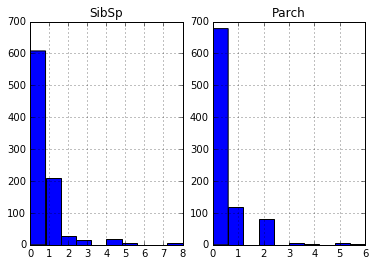

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

fig,axes = plt.subplots(1,2)
train['SibSp'].hist(ax=axes[0])
axes[0].set_title('SibSp')
train['Parch'].hist(ax=axes[1])
axes[1].set_title('Parch')

These columns contain an integer value indicating the number of relatives the passenger has onboard. `SibSp` contains the number of siblings and spouses, and `Parch` contains the number of parents and children.

We'll take a look at survival rate for different values of the columns.

In [6]:
train.pivot_table(index=['SibSp'],values=['Survived'])

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [7]:
 train.pivot_table(index=['Parch'],values=['Survived'])

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


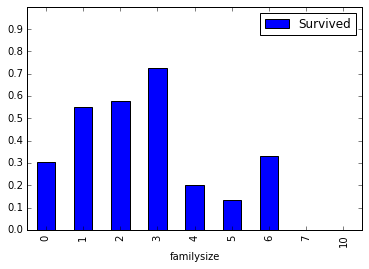

In [8]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()


Having a few relatives on board increased a passenger's chance of surivival. Only 30% of the passengers who had no family onboard survived.

## Feature Engineering

Lets create a feature that indicates whether the passenger was alone with no family members onboard.

In [9]:
def create_isalone(df):
    df['isalone'] = (df['SibSp'] + df['Parch']) == 0
    return df

In [10]:
train = create_isalone(train)
holdout = create_isalone(holdout)

## Feature Selection

We'll create a function to handle automatic feature selection using skleanrn's `RFECV()` to recursively eliminate features.

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Create train and target 
    all_X = df.select_dtypes(exclude=['object','category']) # reduce to numeric
    all_X = all_X.drop('PassengerId',axis=1)
    all_X = all_X.dropna(axis=1)
    all_y = all_X.pop('Survived')
    
    # Instantiate model and feature selector
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf,cv=10)
    
    selector.fit(all_X,all_y)
    
    selected_columns = all_X.columns[selector.support_]
    print(selected_columns)
    return selected_columns   
features = feature_selection(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


The automatic feature selection is reducing our training data to the 18 most impactful columns as determined by an untuned random forest model.

## Model Selection and Tuning

Next we will write a function to perform grid search on three difference algorithms to determine which is best for our data and with what hyperparameters.

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df,features):
    #Split dataframe into train and target
    all_X = df[features]
    all_y = df['Survived']
    
    #Create dictionary of models and hyperparams to try
    models = [{
                  "name": "KNeighborsClassifier",
                  "estimator": KNeighborsClassifier(),
                  "hyperparameters":
                    {
                        "n_neighbors": range(1,20,2),
                        "weights": ["distance", "uniform"],
                        "algorithm": ["ball_tree", "kd_tree", "brute"],
                        "p": [1,2]
                    }
               },
               {
                   "name": "LogisticRegression",
                   "estimator": LogisticRegression(),
                   "hyperparameters":
                   {
                       "solver": ["newton-cg","lbfgs","liblinear"]
                   }
               },
               {
                   "name": "RandomForestClassifier",
                   "estimator": RandomForestClassifier(),
                   "hyperparameters":
                   {
                       "n_estimators":[4,6,9],
                       "criterion":["entropy","gini"],
                       "max_depth":[2,5,10],
                       "max_features":["log2","sqrt"],
                       "min_samples_leaf": [1,5,8],
                       "min_samples_split": [2,3,5]
                   }
               }]
    
    for model in models:
        print('\n' + model["name"] + ":  ")
        gs = GridSearchCV(model["estimator"],param_grid=model["hyperparameters"])
        gs.fit(all_X,all_y)
        model['best_params'] = gs.best_params_
        model['best_score'] = gs.best_score_
        model['best_estimator'] = gs.best_estimator_
        model['results'] = pd.DataFrame(gs.cv_results_)
        print('    Best Parameters:', gs.best_params_)
        print('    Score:', gs.best_score_)
        
    return models

model_results = select_model(train,features)                       
    


KNeighborsClassifier:  
    Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'algorithm': 'brute'}
    Score: 0.7609427609427609

LogisticRegression:  
    Best Parameters: {'solver': 'liblinear'}
    Score: 0.8170594837261503

RandomForestClassifier:  
    Best Parameters: {'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 9}
    Score: 0.8338945005611672


## Submitting to Kaggle
We create a function to create a Kaggle submission file.

In [36]:
def save_submission_file(model,features,filename='submission.csv'):
    predictions = model.predict(holdout[features])
    submission_df = holdout['PassengerId'].to_frame()
    submission_df['Survived'] = predictions
    submission_df.to_csv(filename,index=False)
    
best_score = 0
best_model = None
for model in model_results:
    if model['best_score'] > best_score:
        best_score = model['best_score']
        best_model = model['best_estimator']

save_submission_file(best_model,features)

# Conclusion

Now we have a workflow that we can easily tweak to try and get better entries to the Titanic Surival Kaggle competition.

If we're not satisfied with our last submission, we go back to the top. First, we can explore the data more including the features we have previously created. Then we can think of new features to engineer that may help our model. Finally, we run our automatic steps of feature selection, model selection, and submission creation to see if our new features helped at all.

## Next Steps

* Continue to explore the data and create new features, following the workflow and using the functions we created.
* Read more about the titanic and this Kaggle competition to get ideas for new features.
* Use some different algorithms in the `select_model()` function, like support vector machines, stochastic gradient descent or perceptron linear models.
* Experiment with `RandomizedSearchCV` instead of `GridSearchCV` to speed up the `select_model()` function.